In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

import pickle

# Load the embeddings_index from the pickle file
with open('/content/drive/MyDrive/embeddings_index.pkl', 'rb') as f:
    embeddings_index = pickle.load(f)

In [4]:
# Load intents
with open('intentsModifiedVersion.json', 'r') as f:
    data = json.load(f)

texts = []
labels = []

# Iterate through each intent
for intent in data['intents']:
    # Iterate through each pattern
    for pattern in intent['patterns']:
        # Append the preprocessed pattern to the texts list
        texts.append(pattern.lower())
        # Append the intent's tag to the labels list
        labels.append(intent['tag'])

# Tokenize the texts
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = max(len(seq) for seq in sequences)  # Set sequence length to the max length of any sentence
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [5]:
for intent in data['intents']:
    # Iterate through each pattern
    if intent['tag'] == "StudentVisa_ApplicationRequirements":
      print(intent['responses'])

['You can apply for a Student visa to study in the UK if you’re 16 or over and you: have been offered a place on a course by a licensed student sponsor have enough money to support yourself and pay for your course - the amount will vary depending on your circumstances can speak, read, write and understand English have consent from your parents if you’re 16 or 17 - you’ll need evidence of this when you apply If you’re 16 or 17 and you want to study at an independent school in the UK, you may be eligible for a Child Student visa instead. This visa has replaced the Tier 4 (General) student visa.']


In [6]:
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300  # Should match dimensions of GloVe embeddings
embedding_matrix = np.zeros((len(texts), maxlen, embedding_dim))
for i, sequence in enumerate(padded_sequences):
    for j, word_index in enumerate(sequence):
        if word_index != 0:  # Skip padding zeroes
            embedding_vector = embeddings_index.get(tokenizer.index_word[word_index])
            if embedding_vector is not None:
                embedding_matrix[i][j] = embedding_vector

In [7]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(embedding_matrix, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)


In [11]:
n_classes = len(np.unique(encoded_labels))

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
def model_builder(hp):
  model = Sequential()
  hp_units_dense = hp.Int('dense_units', min_value=200, max_value=320, step=20)
  model.add(Bidirectional(LSTM(hp.Int('lstm_units',min_value=208,max_value=360,step=32))))
  model.add(Dense(units = hp_units_dense, activation='relu',kernel_regularizer='l2'))
  hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
  model.add(Dropout(hp_dropout))
  model.add(Dense(n_classes, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2])

  model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=hp_learning_rate),
              metrics=['accuracy'])

  return model


In [ ]:
import keras_tuner as kt
tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     max_trials=100,
                     directory='my_dir',
                     project_name='intenClassification',
                        overwrite=True)

In [ ]:
tuner.search_space_summary()

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

# Print a summary of the results
tuner.results_summary()

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best LSTM units:", best_hyperparameters.get('lstm_units'))
print("Best Dense units:", best_hyperparameters.get('dense_units'))
print("Best learning rate:", best_hyperparameters.get('learning_rate'))
print("Best Dense units:", best_hyperparameters.get('dense_units'))


Trial 100 Complete [00h 02m 28s]
val_accuracy: 0.7714285850524902

Best val_accuracy So Far: 0.8571428656578064
Total elapsed time: 03h 10m 44s
Results summary
Results in my_dir/intenClassification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 070 summary
Hyperparameters:
dense_units: 240
lstm_units: 208
dropout: 0.5
learning_rate: 0.01
Score: 0.8571428656578064

Trial 088 summary
Hyperparameters:
dense_units: 220
lstm_units: 208
dropout: 0.4
learning_rate: 0.01
Score: 0.8571428656578064

Trial 001 summary
Hyperparameters:
dense_units: 200
lstm_units: 240
dropout: 0.5
learning_rate: 0.01
Score: 0.8476190567016602

Trial 098 summary
Hyperparameters:
dense_units: 200
lstm_units: 240
dropout: 0.2
learning_rate: 0.01
Score: 0.8380952477455139

Trial 015 summary
Hyperparameters:
dense_units: 300
lstm_units: 240
dropout: 0.1
learning_rate: 0.01
Score: 0.8285714387893677

Trial 024 summary
Hyperparameters:
dense_units: 200
lstm_units: 208
dropout: 0.5
learning_

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model)

In [ ]:
best_model.build(input_shape=(None, *X_train.shape[1:]))
best_model.save('intenClassification.h5')

In [ ]:
def classify_intent(user_input):
    # Tokenize and pad the user input
    user_sequence = tokenizer.texts_to_sequences([user_input])
    user_padded = pad_sequences(user_sequence, maxlen=maxlen, padding='post')

    # Create an embedding for the user input
    user_embedding = np.zeros((1, maxlen, embedding_dim))
    for i, word_index in enumerate(user_padded[0]):
        if word_index != 0:  # Skip padding zeroes
            embedding_vector = embeddings_index.get(tokenizer.index_word[word_index])
            if embedding_vector is not None:
                user_embedding[0][i] = embedding_vector

    # Use the model to predict the intent
    prediction = best_model.predict(user_embedding)

    # Decode the prediction to an intent
    predicted_label = np.argmax(prediction, axis=1)[0]
    intent = encoder.inverse_transform([predicted_label])[0]

    return intent

def get_response(predicted_intent):
  for intent in data['intents']:
    # Iterate through each pattern
    if intent['tag'] == predicted_intent:
      return intent['responses']

# Let's test the classify_intent function
user_input = input("Please enter your query: ")
predicted_intent = classify_intent(user_input)
print(f"Predicted Intent: {predicted_intent}")
print(f"Predicted Response: {get_response(predicted_intent)}")


Please enter your query: What is the cost of the student visa?\
1/1 [==============================] - 0s 60ms/step
Predicted Intent: StudentVisa_fees
Predicted Response: ['It costs: £363 to apply for a Student visa from outside the UK £490 to extend or switch to a Student visa from inside the UK You must pay the visa fee for each person that joins you.']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
from tensorflow.keras.models import load_model
loaded_model = load_model('intentClassificationBestModel.h5')
y_pred = loaded_model.predict(X_test)


4/4 [==============================] - 1s 37ms/step


In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

Confusion matrix, without normalization


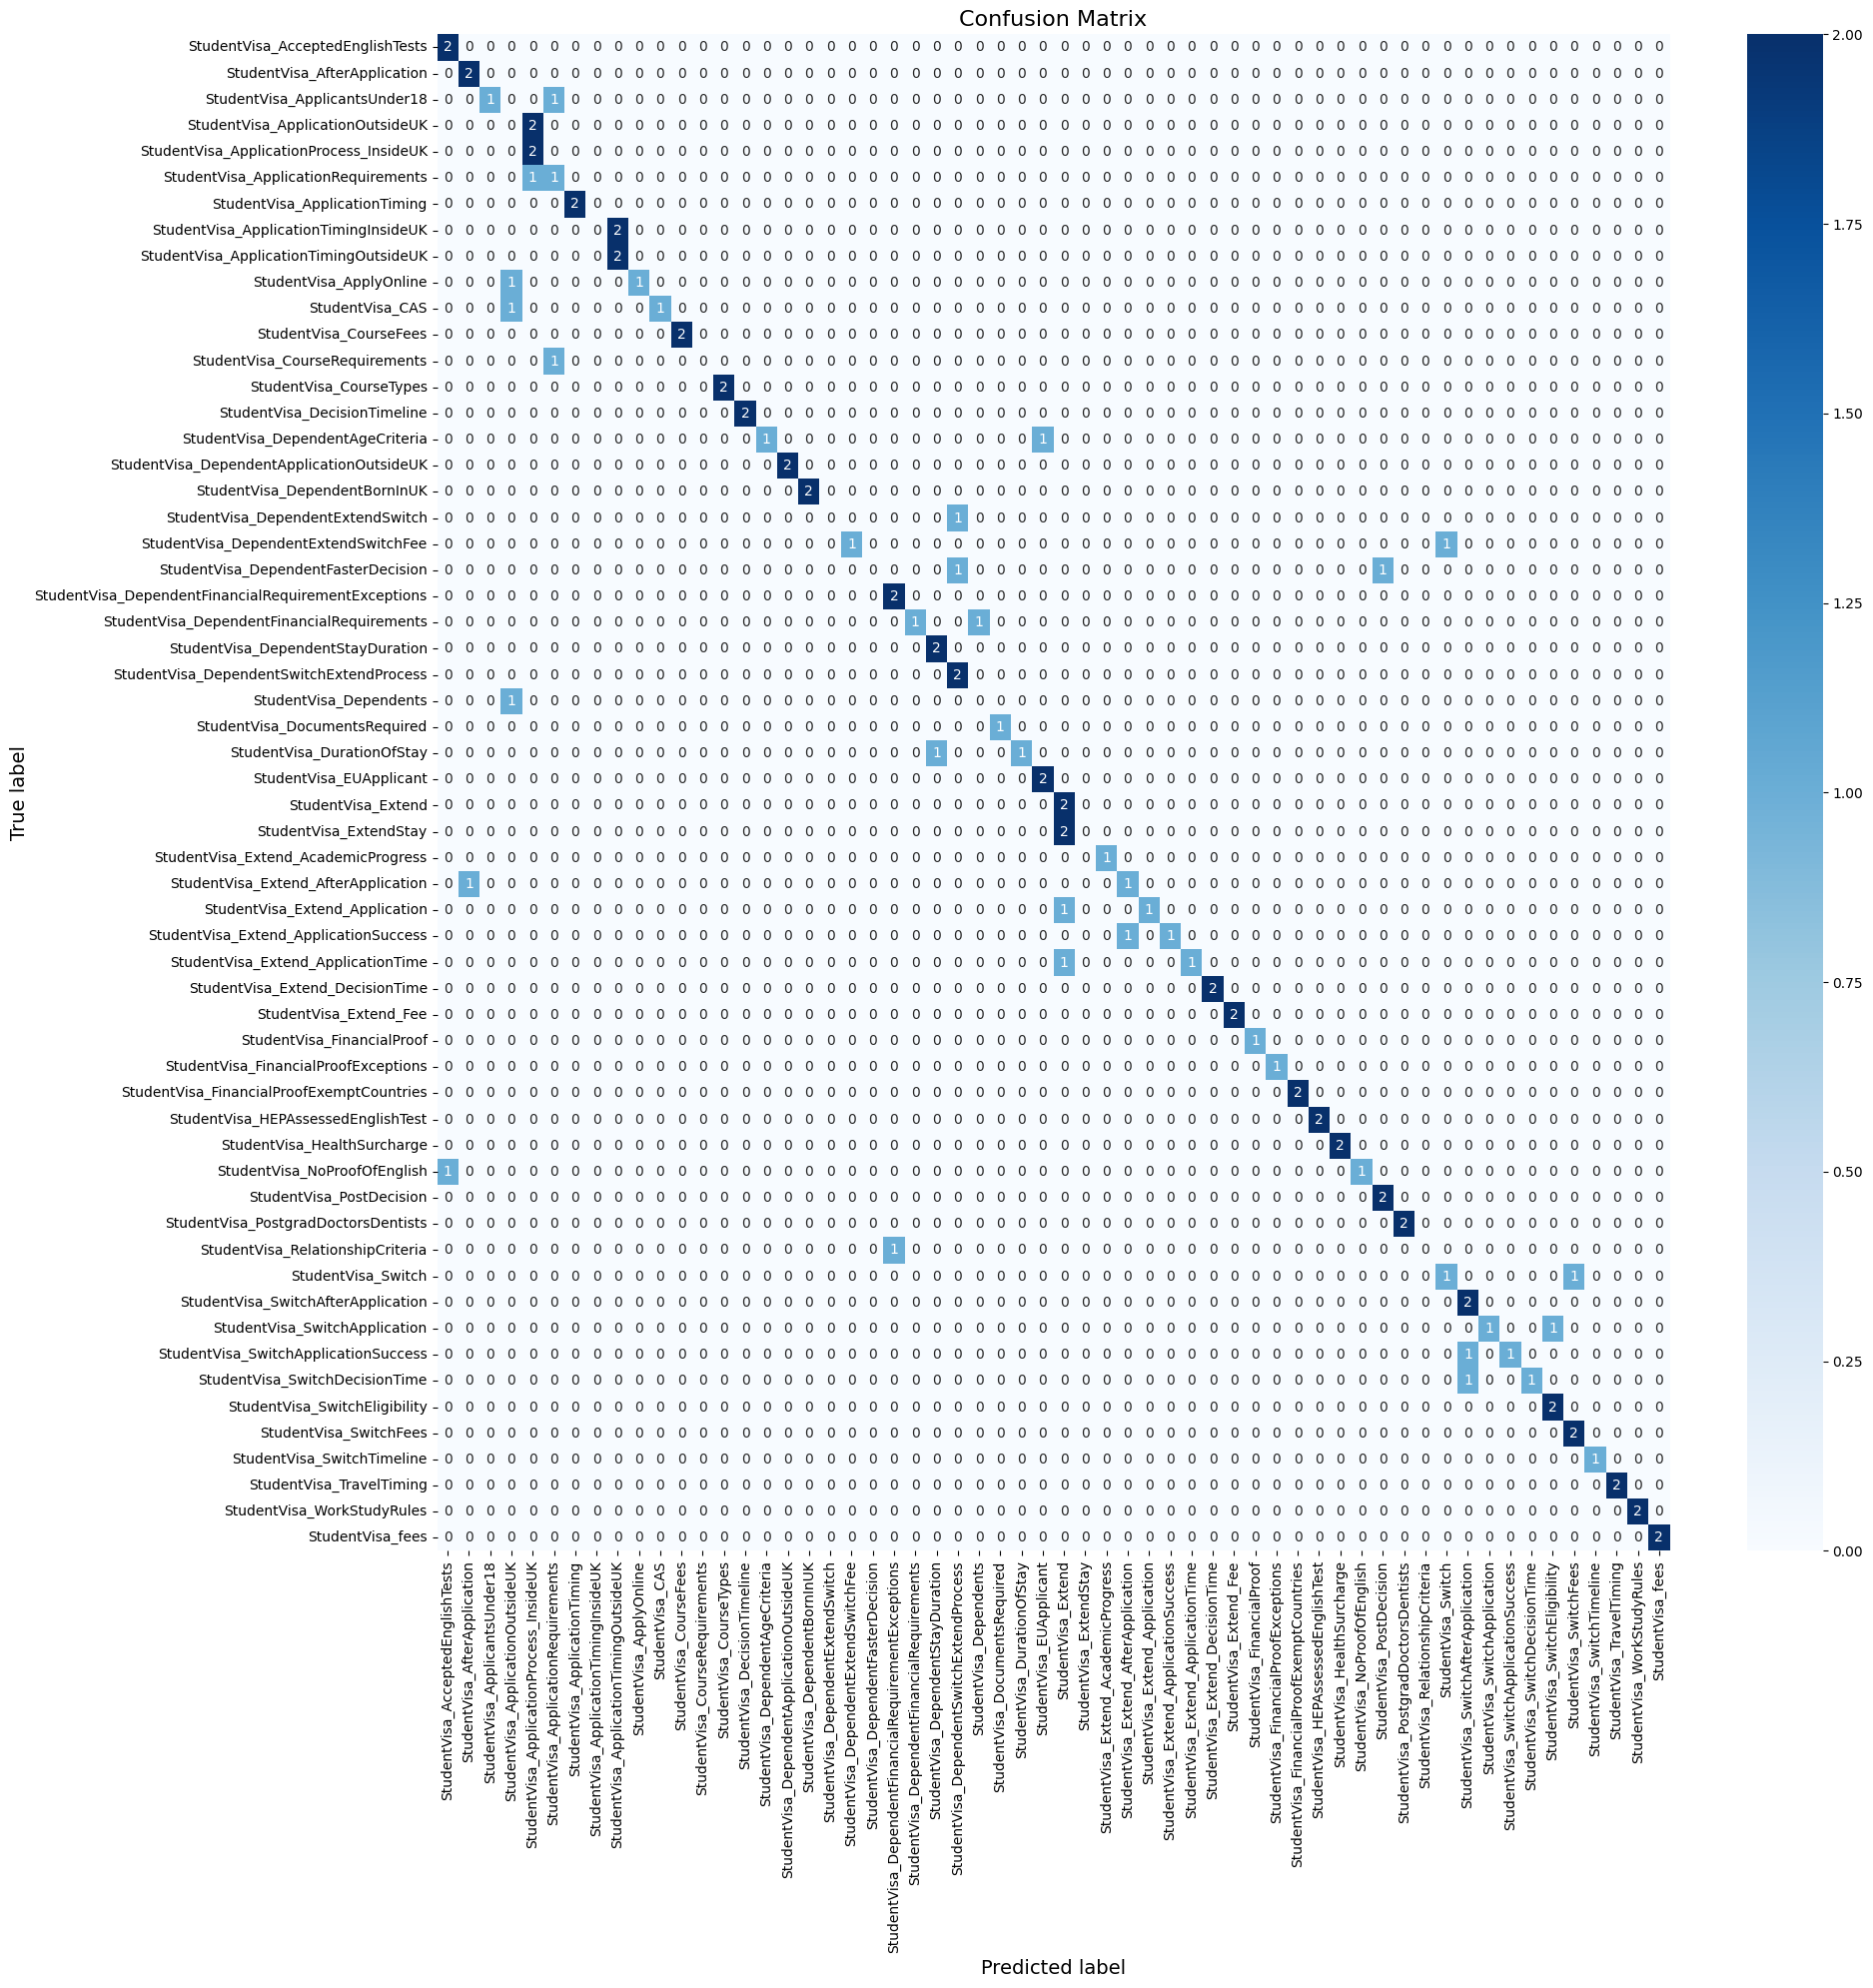

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20, 20))  # Increase figure size

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    sns.heatmap(cm, annot=True, cmap=cmap, fmt=".2f" if normalize else "d",
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 10})  # Adjust font size of annotations

    plt.title(title, size=16)
    plt.ylabel('True label', size=14)
    plt.xlabel('Predicted label', size=14)
    plt.xticks(rotation=90, size=10)  # Rotate x-axis labels
    plt.yticks(size=10)
    plt.tight_layout()

# Generate the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Call the function to plot the matrix
plot_confusion_matrix(cm, classes=encoder.classes_, normalize=False, title='Confusion Matrix')
plt.show()